# Optimal Transport Performance

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import os
import glob
import ot
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
path='../data/images/'
band_names=['Red','Green','Blue','NIR','SWIR1','SWIR2','TEMP1','NL']

In [3]:
fps = glob.glob(f'{path}*.npz')
ims = []

for fp in fps:
    im = np.load(fp)['x']
    ims.append(im.T)

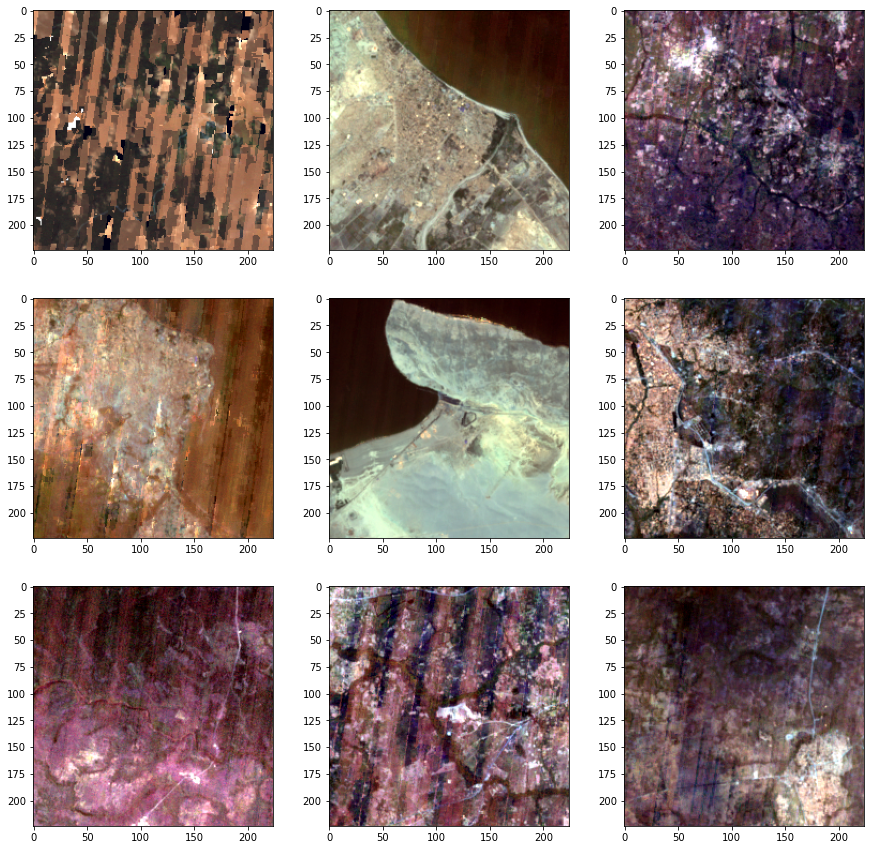

In [4]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    curr_im = ims[i][:,:,:3]
    min_val = np.percentile(curr_im, .5)
    max_val = np.percentile(curr_im, 99.5)
    curr_im = (curr_im - min_val)/(max_val-min_val)
    curr_im[curr_im > 1] = 1
    curr_im[curr_im < 0] = 0
    plt.imshow(curr_im)

In [5]:
file_path = '../data/dhs_image_hists.npz'
npz = np.load(file_path)

image_hists = npz['image_hists']
labels = npz['labels']
locs = npz['locs']
years = npz['years']
nls_center = npz['nls_center']
nls_mean = npz['nls_mean']

In [6]:
loc_dict_path = '../data/dhs_loc_dict.pkl'

with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)

In [7]:
COUNTRIES = ['angola', 'benin', 'burkina_faso', 'cameroon', 'cote_d_ivoire',
       'democratic_republic_of_congo', 'ethiopia', 'ghana', 'guinea',
       'kenya', 'lesotho', 'malawi', 'mali', 'mozambique', 'nigeria',
       'rwanda', 'senegal', 'sierra_leone', 'tanzania', 'togo', 'uganda',
       'zambia', 'zimbabwe']

In [8]:
df_data = []
for label, loc, nl_mean, nl_center in zip(labels, locs, nls_mean, nls_center):
    lat, lon = loc
    loc_info = loc_dict[(lat, lon)]
    country = loc_info['country']
    year = int(loc_info['country_year'][-4:])  # use the year matching the surveyID
    urban = loc_info['urban']
    household = loc_info['households']
    row = [lat, lon, label, country, year, urban, nl_mean, nl_center, household]
    df_data.append(row)
df = pd.DataFrame.from_records(
    df_data,
    columns=['lat', 'lon', 'wealthpooled', 'country', 'year', 'urban', 'nl_mean', 'nl_center', 'households'])

In [9]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(len(locs), dtype=np.int32)  # np.array of country labels
wealth_labels = np.zeros(len(locs), dtype=np.float32)

for i, loc in enumerate(locs):
    country = loc_dict[tuple(loc)]['country']
    wealth_labels[i] = loc_dict[tuple(loc)]['wealthpooled']
    country_indices[country].append(i)

for i, country in enumerate(COUNTRIES):
    country_indices[country] = np.asarray(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

## Task:
Given reference country for which the linear regression model was trained on to predict wealth given the 8 channel image, we want to optimal transport the images for another country to this country to use the same linear regression model.

### Train Model
Let Angola be the reference country for which the model was trained on

In [10]:
ixs = country_labels==COUNTRIES.index('angola')
angola_hists = image_hists[ixs]
angola_hists = angola_hists.reshape((angola_hists.shape[0], angola_hists.shape[1]*angola_hists.shape[2]))
angola_wealth = wealth_labels[ixs]
angola_hists.shape, angola_wealth.shape

((855, 816), (855,))

In [19]:
ntrain = 9*ixs.sum()//10
X_train = angola_hists[:ntrain,:]
X_test = angola_hists[ntrain:,:]
y_train = angola_wealth[:ntrain]
y_test = angola_wealth[ntrain:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((769, 816), (769,), (86, 816), (86,))

In [20]:
reg = LinearRegression().fit(X_train, y_train)

In [21]:
mse_train = np.mean((y_train - reg.predict(X_train))**2)
mse_test = np.mean((y_test - reg.predict(X_test))**2)

mse_train, mse_test

(0.062113388706644075, 3.205502982037435)

### Optimal transport to use this model on other countries

In [23]:
ixs = country_labels==COUNTRIES.index('benin')
benin_hists = image_hists[ixs]
benin_hists = benin_hists.reshape((benin_hists.shape[0], benin_hists.shape[1]*benin_hists.shape[2]))
benin_wealth = wealth_labels[ixs]
benin_hists.shape, benin_wealth.shape

((746, 816), (746,))